In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
import statistics
import nltk
import re
from scipy import stats
from venn import venn
import matplotlib
import squarify
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords  
from gensim.parsing.preprocessing import STOPWORDS
from sklearn import preprocessing
#nltk.download('stopwords')
from nltk.tokenize import word_tokenize  
%matplotlib inline

In [2]:
recipes = pd.read_csv('data/large_data/recipes.csv')
ingredient_freq = pd.read_csv('data/recipes/ingredient_freq.csv')
interactions = pd.read_csv('data/large_data/RAW_interactions.csv')

In [3]:
def calc_ingredient_ratings(ingredient_list, ingredient_freq= ingredient_freq):
    #print(ingredient_list) 
    rating = 0
    for ingredient in ingredient_list:
        try:
            freq = ingredient_freq.loc[ingredient]
        except:
            freq = 0
        rating += freq
    return rating

In [4]:
def calc_overall_score(recipe_list, priority):
    recipe_list['rating_score'] = recipe_list['avg_rating']*recipe_list['n_ratings']
    #normalize minutes, ratings, ingredient_score, number of steps, number of ingredients
    #x = recipe_list[['minutes','rating_score', 'ingredient_score','n_steps','n_ingredients']]
    #min_max_scaler = preprocessing.MinMaxScaler()
    #x_scaled = min_max_scaler.fit_transform(x)
    #df = pd.DataFrame(x_scaled, columns = ['minutes','rating_score', 'ingredient_score','n_steps','n_ingredients'] )
    #print(df.head())
#     overall_score =  df['rating_score']*priority['C'] + \
#                 df['ingredient_score']*priority['D'] - df['n_steps']*priority['A'] - \
#                 df['n_ingredients']*priority['B'] - df['minutes']*priority['E']
    overall_score = stats.zscore(recipe_list['minutes'])*priority['E'] + \
                recipe_list['rating_score']*priority['C'] + \
                recipe_list['ingredient_score']*100*priority['D'] + \
                stats.zscore(recipe_list['n_steps'])*priority['A'] + \
                stats.zscore(recipe_list['n_ingredients'])*priority['B'] 
    return overall_score

In [5]:
def get_recipes(search_phrase, recipes, priority):
    recipe_list = recipes.loc[recipes['name'].str.contains(search_phrase, case=False)].copy()
    recipe_list['ingredient_score'] = recipe_list['mod_ingredients'].apply(calc_ingredient_ratings)
    recipe_list['overall_score'] = calc_overall_score(recipe_list, priority)
    return recipe_list

In [6]:
def show_top_recipes(recipe_list):
    html = 'https://www.food.com/recipe/'
    common_ingredients = recipe_list['mod_ingredients'].apply(literal_eval).explode().value_counts()
    cmap = matplotlib.cm.Blues
    norm = matplotlib.colors.Normalize(vmin=min(common_ingredients), vmax=max(common_ingredients))
    colors = [cmap(norm(value)) for value in common_ingredients]
    squarify.plot(sizes=common_ingredients[:10], label=common_ingredients.index[:10], alpha=.5, text_kwargs={"wrap": True})
    plt.axis('off')
    plt.show()
    top_5 = recipe_list.nlargest(5, 'overall_score').copy()
    top_5['recipe_link'] = [f'https://www.food.com/recipe/{ing_id}' for ing_id in top_5['id']]
    return top_5[['name','id','overall_score','recipe_link']]

In [7]:
# text = interactions[interactions['recipe_id'].isin(recipe_list.id)]['review'].apply(str.split).explode()
# text = interactions[interactions['recipe_id'].isin(recipe_list.id)]['review'].apply(word_tokenize).explode()
# text = [word.lower().translate(str.maketrans('', '', str.punctuation)) for word in text]
# print(len(text))
# text = [w.lower() for w in text if not w.lower() in stop_words]
# print(text[0:10])
# text = [word for word in text if re.sub(r'[^\\w\\s]','', word) == word]

In [25]:
def make_wordcloud(recipe_list):
    stop_words = stopwords.words('english')
    stop_words.extend(['i','ive',"i've",'didnt','them', 'little','use','added','good','great', 'think', 'taste',\
                       'recipe', 'used','made','make','still','also','baked','bake','thank','thanks','cup'])
    #stop_words = set(stop_words)
    stop_words = STOPWORDS.union(set(stop_words))
    review_list = interactions[interactions['recipe_id'].isin(recipe_list.id)]['review']
    #print(review_list)
    text = " ".join(str(review) for review in review_list)
    wordcloud = WordCloud(stopwords=stop_words, background_color="white").generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [21]:
def get_priority():
    priority_map = {"A": 1, "B": 1, "C": 1, "D": 1, "E": 1}
    print("""What is your priority for:
            A) Number of Steps
            B) Number of Ingredients
            C) Ratings
            D) Exoticness of Ingredients
            E) Time to Prepare
            """)
    priority = ["A","B","C"]
    priority[0] = input("What is your # 1 Priority?")
    priority[1] = input("What is your # 2 Priority?")
    priority[2] = input("What is your # 3 Priority?")
    
    priority_map[priority[0]] = .4
    priority_map[priority[1]] = .3
    priority_map[priority[2]] = .2
    non_priority = list(set(priority_map.keys()) - set(priority))
    for key in non_priority:
        priority_map[key] = .05
    return priority_map    

In [18]:
def main():
    search_phrase = input('What recipe do you want to search for: ').lower()
    priority = get_priority()   
    #search_words = search_phrase.split(" ")
    #search_words = "|".join("^{}$".format(word) for word in search_words)
    recipe_list = get_recipes(search_phrase, recipes, priority)
    #print(recipe_list)
    #print(interactions[interactions['recipe_id'].isin(recipe_list.id)]['review'])
    make_wordcloud(recipe_list)
    return show_top_recipes(recipe_list)

What recipe do you want to search for: tacos
What is your priority for:
            A) Number of Steps
            B) Number of Ingredients
            C) Ratings
            D) Exoticness of Ingredients
            E) Time to Prepare
            
What is your # 1 Priority?A
What is your # 2 Priority?B
What is your # 3 Priority?C


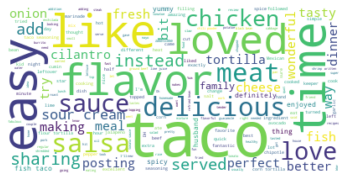

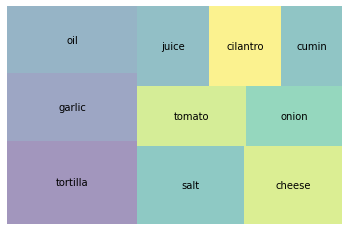

,name,id,overall_score,recipe_link
47750,chipotle roast for tacos sandwiches,59224,150.368847,https://www.food.com/recipe/59224
133338,mini tacos,74301,117.733597,https://www.food.com/recipe/74301
181188,shredded chicken for enchiladas tostadas tacos,169500,108.623316,https://www.food.com/recipe/169500
203353,taco seasoning budget friendly seasoning for...,166030,94.992741,https://www.food.com/recipe/166030
82479,fish tacos and cilantro coleslaw 20 minutes max,100798,90.943214,https://www.food.com/recipe/100798


In [26]:
main()